# Sentiment Analysis of Car Reviews

## Data

Our goal for this project is to carry out sentiment analysis of reviews for Ford motor vehicles. There are 1,382 reviews in the CSV file in total, 691 of which are positive and 691 of which are negative. Each review is labelled with either ‘Pos’ or ‘Neg’ to indicate whether the review has been assessed as positive or negative in the sentiment it expresses. We are treating these labels as a reliable indicator of sentiment and assume that there are no neutral reviews. 

## Task 1

We are going to implement a Naïve Bayes classifier using 80% (1106) of the reviews as training data. The
training data should will be selected at random from the full dataset. The classifier, created using **MultinomialNB** from **scikit-learn**, will be tested using the remaining 20% (276) of the reviews and report the classifier’s performance using a confusion matrix.

To avoid issues of data [leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)
, the classifier should only be trained using data that it has access to from within the training data set. If there are words that only appear in the test data, they should not be part of the classifier. We will ensure sure that the code is able to deal with encountering words in the test data that the classifier has not seen in the training data. 

Some clean up of the data should be performed using it in the classifier. This will include:
- Identifying and excluding all punctuation and words that are not likely to affect sentiment (eg. [stopwords](https://en.wikipedia.org/wiki/Stop_word)). Natural Language Toolkit (NLTK) in Python will be used to process the data.
- ensuring that remaining words are not case sensitive (i.e. the classifier should not distinguish upper/lowercase characters).

The sentiment classifier will use a [bag of words technique](https://en.wikipedia.org/wiki/Bag-of-words_model), in which we will build a vocabulary of individual words that appear in the dataset once it has been cleaned up.

We will attempt to treat minor variations of a word (e.g. ‘fault’, ‘faults’ and ‘faulty’) as instances of the same
word (e.g. ‘fault’) when we are using them in your classifier. We will implement [stemming](https://en.wikipedia.org/wiki/Stemming) as a way of doing this using the **PorterStemmer** function.

For each review a vector will be created, using **CountVectorizer** as input for the classifier, containing EITHER binary values indicating whether a word/stem occurs in the review OR a numerical count of the number of times each word/stem appears.As described above, vectors that are used to train the classifier should only include words that appear in the training data (and not words that only exist within the test data).

First, lets import all the modules



In [1]:
#Importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import re
from IPython.display import display

#Importing necessary from NLTK and scikit-learn
import nltk
from nltk.tokenize import word_tokenize #tokenize words
from nltk.corpus import stopwords #stopwords dataset
from nltk.stem.porter import PorterStemmer #stemming to treat minor variations

from sklearn.naive_bayes import MultinomialNB #to create the Naive Bayes classifier on the data
from sklearn.feature_extraction.text import CountVectorizer #to generate a vector for each review
from sklearn.model_selection import train_test_split #to split the data into training and test sets
from sklearn.metrics import accuracy_score, confusion_matrix #to get the accuracy and confusion matrix of classifier

nltk.download('stopwords') #downloading this so that we get the list of stopwords
nltk.download('punkt') #downloading this so that word_tokenize works
ps = PorterStemmer() #assigns the PorterStemmer needed for stemming
vect = CountVectorizer() #assigns the CountVectorizer needed for generating count vector for reviews



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashley\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashley\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's have a look at the dataset

In [2]:
reviews = pd.read_csv('car_reviews.csv')
display(reviews.head())
display(reviews.info())

,Sentiment,Review
0,Neg,In 1992 we bought a new Taurus and we really ...
1,Neg,The last business trip I drove to San Franci...
2,Neg,My husband and I purchased a 1990 Ford F250 a...
3,Neg,I feel I have a thorough opinion of this truc...
4,Neg,AS a mother of 3 all of whom are still in ca...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  1382 non-null   object
 1   Review     1382 non-null   object
dtypes: object(2)
memory usage: 21.7+ KB


None

We can clearly see there are only 2 columns in the dataset: the sentiment and corresponding review, where both are strings 

Now let's create a function that cleans the strings. We will use this function to clean text in the *Reviews* column.

In [3]:
def clean(string):
    string = string.lower() #convert string to lower case
    string = re.sub('[^a-z]', ' ', string) #replacing non-alphabetical characters with a blank
    tokenize = word_tokenize(string) #tokenize the strings
    stemmed_token_list = [ps.stem(token) for token in tokenize if token not in set(stopwords.words('english'))] #list of stemmed words/tokens
    clean_string = " ".join(stemmed_token_list) #converts list to string
    
    return clean_string 


Now, we are going to store all the processes reviews in a list and show a comparison between an orignal and its cleaned string (review) to clearly demonstrate that words and punctuation, which are unlikely to affect sentiment, have been excluded from the sentiment classifier AND that the remaining words are not being handled in a case sensitive way

In [4]:
processed_reviews = []

for i in range(reviews.shape[0]):
    review = reviews.iloc[i,1]
    clean_review = clean(review)
    processed_reviews.append(clean_review)
    
#Showing comparison between original and cleaned string 
original_string = reviews['Review'][2]
print('Original String:')
print('')
print(original_string)
print('')
print('Clean String:')
print('')
print(processed_reviews[2]) 


    

Original String:

 My husband and I purchased a 1990 Ford F250 and had nothing but problems  we have owned the vehicle approximately two years and it has spent at least half of that time in the shop The first problem was the valve covers were leaking  This problem took three days in the shop  When we went to pick it up  we found that the mechanic at the dealership did not replace parts that he had to take off  This took an additional week  Because of the poor design  fixing this vehicle was not found to be cheap  nor could just any mechanic do the work Next   within one week  the serpentine belt came off the pulleys and sheared off the air conditioning power plug  This also took nearly a week to fix  Cause of this problem was unknown Next  the clean air pump broke  again within a week  This took about four days to fix  When I picked up the truck after the air pump  I didn t realize at the time that the mechanic had not hooked back up a hose to the transmission  So  after driving it for

To show how stemming works, the code cell below clearly demonstrates that words with the same stem have been appropriately recognised and treated as variations of the 3 different stems.

In [5]:
#few examples of words having the same stem
list1 = ['developer', 'developing', 'developed', 'develops']
list2 = ['hammers', 'hammered', 'hammering']
list3 = ['join', 'joining', 'joined', 'joins']

#store stemmed words in a list
stem1 = [ps.stem(word) for word in list1]
stem2 = [ps.stem(word) for word in list2]
stem3 = [ps.stem(word) for word in list3]

print('')
print(str(list1) + ": " + str(stem1))
print('')
print(str(list2) + ": " + str(stem2))
print('')
print(str(list3) + ": " + str(stem3))
print('')


['developer', 'developing', 'developed', 'develops']: ['develop', 'develop', 'develop', 'develop']

['hammers', 'hammered', 'hammering']: ['hammer', 'hammer', 'hammer']

['join', 'joining', 'joined', 'joins']: ['join', 'join', 'join', 'join']



To have a better understanding of how to get the count vector, we will look through 3 reviews of the dataset and see the number of times that a word (or word stem) appears

In [6]:
#going through first 3 reviews in the dataset
for i in range(3):
    review = reviews['Review'][i] #get review
    clean_review = clean(review) #get clean review

    vector = vect.fit_transform([clean_review]) #converts review into a vector of token counts
    df = pd.DataFrame(vector.A, columns = vect.get_feature_names()) #store vector in dataframe
    
    #Display count vector for a review
    print('')
    print('Count vector for review ' + str(i+1) + ':')
    display(df)
    


Count vector for review 1:


,anyway,back,batteri,bought,buy,car,card,care,chang,comfort,...,take,tank,tauru,thee,think,tire,tri,version,way,would
0,1,1,1,2,1,1,1,1,1,1,...,1,1,3,1,1,1,1,1,1,2



Count vector for review 2:


,allow,anoth,anyon,area,basi,better,breez,busi,buy,car,...,uncomfort,unnecessarili,us,usag,usual,weigh,well,went,work,would
0,1,1,1,1,1,1,1,2,1,7,...,4,1,3,1,1,1,1,1,1,2



Count vector for review 3:


,addit,air,also,approxim,back,balanc,began,belt,bought,broke,...,valv,vehicl,vibrat,week,went,within,work,wrong,yard,year
0,1,3,1,1,1,1,1,4,1,1,...,1,4,1,5,2,3,1,1,1,1


We are going to split up the test and training data using an 80/20 split.


In [7]:
X = vect.fit_transform(processed_reviews).toarray()
Y = reviews.iloc[:, 0]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2)

print('No. of reviews in the training split is: ' + str(len(X_train)))
print('No. of reviews in the test split is: ' + str(len(X_test)))

No. of reviews in the training split is: 1105
No. of reviews in the test split is: 277


We will use MultinomialNB from sci-kit learn to train the classifier with the training sets. The classifier will then be implemented on test data. We will also find out the accuracy score. Each classifier will be run again on the data it was trained on to show  that only the training data has been used up to the point where the model has been trained. Also, with MulitnomialNB, the code able to cope with words that appear in the test data but not in the training dataset

In [8]:
#train classifier with training data using MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, Y_train)

#print lenght of training sets
print('Length of X_train: ' + str(len(X_train)))
print('Length of Y_train: ' + str(len(Y_train)))
print('')

Y_pred = classifier.predict(X_test) #predicts sentiment for the test data 

#get confusion matrix and accuracy score
training_accuracy = classifier.score(X_train, Y_train)

matrix_cf = confusion_matrix(Y_test, Y_pred)
test_accuracy = accuracy_score(Y_test, Y_pred)



print('Accuracy on the training data is: %.2f%% ' % (training_accuracy * 100.0))
print('Accuracy on the test data is: %.2f%% ' % (test_accuracy * 100.0))
print('')


Length of X_train: 1105
Length of Y_train: 1105

Accuracy on the training data is: 91.58% 
Accuracy on the test data is: 79.06% 



Confusion matrix:


<AxesSubplot:>

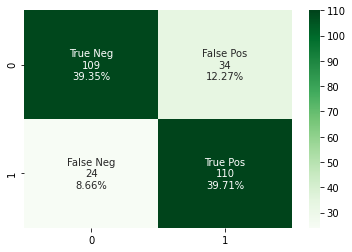

In [9]:
def plot_matrix(matrix):
    
    label_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    label_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    label_percentages = ["{0:.2%}".format(value) for value in (matrix.flatten() / np.sum(matrix))]
    
    heatmap_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip (label_names, label_counts, label_percentages)]
    heatmap_labels = np.asarray(heatmap_labels).reshape(2,2)
    
    
    plot = sns.heatmap(matrix, fmt = '', annot = heatmap_labels, cmap='Greens')
    
    return plot

print('Confusion matrix:')
plot_matrix(matrix_cf)

## Task 2

The first task only considered individual words and not many words at once (using unigrams). To incorporate multi-word phrases in the classifier, we will use bigrams as well as unigrams to improve text classification **[1]**. When we use bigrams with unigrams, it means that we look at words in pairs as well as individually. We are doing this so that the classifier that does not classify a sentence having a positive sentiment accidentally. For example, in the sentence **Today was not great**, if we use unigrams to train the classifier it will ignore the "not" and classify this sentence as a positive sentiment when it is clearly expressing a negative one. However, if we use bigrams as well as unigrams to train the classifier, it will result in classifying the sentence as expressing a negative sentiment since it considers the phrase "not great". We can use bigrams only to improve the performance but it will be better to use bigrams as well as unigrams to significantly improve the performance **[2]**.

### **References**
**[1]** Chade-Meng Tan; Yuan-Fang Wang; Chan-Do Lee (2002). The use of bigrams to enhance text categorization. 38(4) 529–546

**[2]** Igor Assis Braga, Maria Carolina Monard, Edson Takashi Matsubara. Combining Unigrams and Bigrams in
Semi-Supervised Text Classification. Mathematics and Computer Science Institute
University of Sao Paulo, Sao Carlos, SP 13566-590, Brazil {igorab,mcmonard,edsontm}@icmc.usp.br

We will demonstrate how to implent bigrams as well as unigrams in the classifier and compare the results of Task 2 with Task 1


Accuracy on the training data is: 100.00% 
Accuracy on the test data is: 80.87% 

Confusion matrix:


<AxesSubplot:>

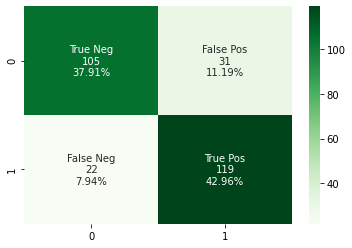

In [10]:
vector2 = CountVectorizer(ngram_range=(1,2)) 
#considers bigrams as well as unigrams, defaullt setting has ngram_range=(1,1) which only includes unigrams

#Assign X and Y
X2 = vector2.fit_transform(processed_reviews).toarray()
Y2 = reviews.iloc[:, 0]

#Split training and test data
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.2)

#train classifier with training data using MultinomialNB
classifier2 = MultinomialNB()
classifier2.fit(X2_train, Y2_train)

Y2_pred = classifier2.predict(X2_test) #predicts sentiment for the test data

#get updated confusion matrix and accuracy score
matrix_cf2 = confusion_matrix(Y2_test, Y2_pred)
test_accuracy2 = accuracy_score(Y2_test, Y2_pred)

#display confusion matrix and accuracy
training_accuracy2 = classifier2.score(X2_train, Y2_train)

print('Accuracy on the training data is: %.2f%% ' % (training_accuracy2 * 100.0))
print('Accuracy on the test data is: %.2f%% ' % (test_accuracy2 * 100.0))
print('')
print('Confusion matrix:')
plot_matrix(matrix_cf2)

We can see the that accuracy on the training data is 100%, which means that all the sentiments have been predicted correctly in the training set. The test accuracy has a slight increase of about 2.5% but that is not too significant. 

The number of False positives have decreased significantly and True Negatives have increased meaning that the classifier had done a better job in identifying sentences with negative sentiments. Also we can see that the True Positives have decreased a bit.

However, we see an increase in false negatives by 7 which is not too significant. But, it could be the fact that using incorporating bigrams might have made the classifier mistakenly seeing a positive sentiment as a negative one. 

In conclusion, incorporating bigrams with unigrams in the classifier will help increase accuracy and decrease the chances of getting false positive sentiment but it could lead to increasing chances of the classifier mistakenly seeing a positive sentiment as a negative one.